In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [6]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
import copy

## params

In [7]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
#model_path = data_folder + 'best_model_20240411_no_sim1.ckpt'
model_path = data_folder + 'best_model_multitasking_pretraining_2.ckpt'

In [8]:
config=Config()

In [9]:
config.D_MODEL=512
config.N_LAYERS=5

In [10]:
MULTITASKING=5

## open janssen data

In [11]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [12]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                 | 2033/100000000 [00:01<19:57:49, 1391.38it/s]


We reached the end of the array at index 2033


## open ref data

In [13]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [14]:
all_spectrums_reference= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [15]:
all_spectrums_reference[0].params

{'pepmass': (545.0, None),
 'charge': [0],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': '20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Scytonemin M+H',
 'pi': 'Gerwick',
 'datacollector': 'Amanda',
 'smiles': 'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
 'inchi': 'InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17-25-33-29(23-5-1-3-7-27(23)37-33)31(35(25)41)32-30-24-6-2-4-8-28(24)38-34(30)26(36(32)42)18-20-11-15-22(40)16-12-20/h1-18,39-40H/b25-17+,26-18+',
 'inchiaux': 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00000001550',
 'scans': '1'}

In [16]:
all_spectrums_gnps = [s for s in all_spectrums_reference if s.params['spectrumid'].startswith('CCMS')]

In [17]:
all_spectrums_nist=[s for s in all_spectrums_reference if not(s.params['spectrumid'].startswith('CCMS'))]

## Preprocessing

## Find those instances that are IN reference

In [18]:
all_spectrums_janssen_processed= [copy.deepcopy(s) for s in all_spectrums_janssen]


In [19]:
pp=Preprocessor()
### remove extra peaks in janssen
all_spectrums_janssen_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_janssen_processed]

all_spectrums_janssen = [s_original for s_original, s_processed in zip(all_spectrums_janssen,all_spectrums_janssen_processed) if len(s_processed.mz)>=6]

In [20]:
all_spectrums_reference_processed= [copy.deepcopy(s) for s in all_spectrums_reference]

In [21]:
all_spectrums_reference_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_reference_processed]
    
all_spectrums_reference = [s_original for s_original, s_processed in zip(all_spectrums_reference,all_spectrums_reference_processed) if len(s_processed.mz)>=6]

## Find identical appearences in referencd

In [22]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]

In [23]:

janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [24]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_in_ref]

In [25]:
filtered_canon_smiles_janssen= [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]

In [26]:
ref_indexes_mapped = [[i for i,t in enumerate(canon_smiles_reference) if t==s ]  for s in (filtered_canon_smiles_janssen)]

In [27]:
ref_indexes_mapped

[[186926,
  186927,
  186928,
  186929,
  186930,
  186931,
  186932,
  186933,
  186934,
  186935,
  186936,
  186937],
 [224642],
 [7239],
 [4987, 4988, 4989, 4990, 7059, 28989, 29223, 29449, 29808],
 [40296, 40297, 40298, 40299, 40300, 40301, 40302],
 [29029, 29280, 29375, 29679, 29881, 30233, 30415, 30457, 30505, 30919, 39414],
 [17908,
  18099,
  33386,
  34254,
  34315,
  34353,
  34755,
  34827,
  35310,
  35620,
  78748,
  78749,
  78750,
  78751,
  78752,
  78753,
  78754,
  78755],
 [247405,
  248644,
  248783,
  248791,
  248813,
  248818,
  248880,
  249752,
  249799,
  249886,
  249888,
  249911,
  249968,
  250357,
  250360,
  250436,
  250486,
  250511,
  250592,
  250598,
  250618,
  250761,
  250774,
  250785,
  250798,
  250800,
  255778,
  255779,
  255780,
  255781,
  255782,
  255783,
  255784,
  255785,
  255786,
  255787,
  255788,
  255789,
  255790],
 [453, 6636, 10381, 17506],
 [4922,
  4923,
  4924,
  4925,
  4926,
  21260,
  22425,
  22635,
  22854,
  22959,

## load encoder

In [28]:
#encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS), multitasking=MULTITASKING, config=config)

Using cosine library from Pytorch?: True


## data loader

In [29]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)


Preprocessing all the data ...


1577it [00:00, 2321.57it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [30]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


274310it [00:06, 44473.30it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [31]:
dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


263745it [00:05, 50026.89it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [32]:
dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


62641it [00:01, 34134.50it/s]


Finished preprocessing 
loading data
Normalizing intensities


## forward

In [33]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [34]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [35]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [36]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities

In [37]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)

In [38]:
similarities.shape

(1577, 274310)

## heat map

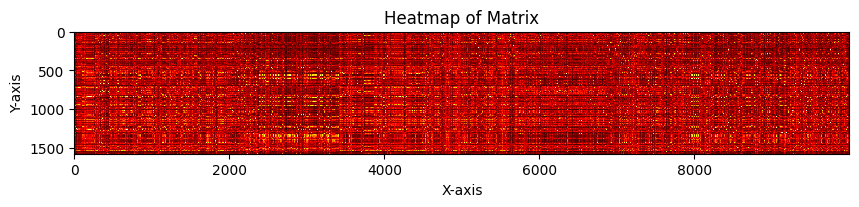

In [39]:
plt.figure(figsize=(10,100))
plt.imshow(similarities[:, 0:10000], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Show PCA

In [40]:
from src.analog_discovery.pca_embeddings import PCAEmbeddings

In [41]:
pca = PCAEmbeddings()

In [42]:
pca.fit(embeddings_reference)

In [43]:
pca_ref= pca.transform(embeddings_reference)

In [44]:
pca_janssen= pca.transform(embeddings_janssen)

In [45]:
#pca_nist= pca.transform(embeddings_nist)

In [46]:
#pca_gnps= pca.transform(embeddings_gnps)

In [47]:
from src.plotting import Plotting

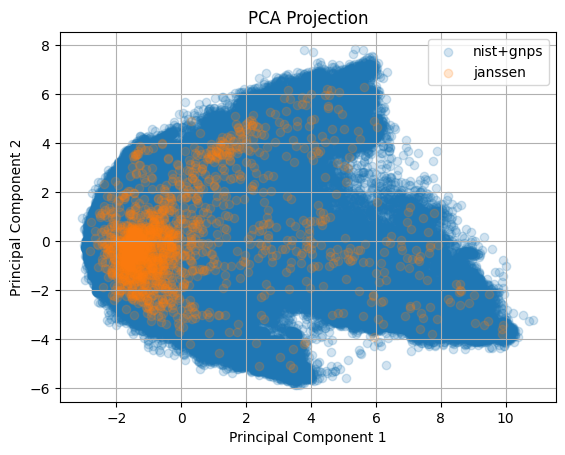

In [48]:
Plotting.plot_n_pca([pca_ref, pca_janssen,], ['nist+gnps','janssen', ], alpha=0.2)

## Filtering

In [49]:
similarities.shape

(1577, 274310)

In [50]:
## get the precursor masses of janssen
mz_janssen = np.array([s.precursor_mz for s in all_spectrums_janssen])

In [51]:
## get the precursor masses of reference
mz_ref = np.array([s.precursor_mz for s in all_spectrums_reference])

In [52]:
## create a mask that says that for each row, if the element is withing the range of 1ppm
tolerance=0.01
mask_similarities =np.zeros(similarities.shape)
#mask_similarities =np.ones(similarities.shape)
for i,mz in enumerate(mz_janssen):
    high_range= mz + tolerance*mz
    low_range = mz - tolerance*mz
    mask_similarities[i,(mz_ref< high_range)&(mz_ref > low_range)] =1
    

In [53]:
np.sum(mask_similarities, axis=1)

array([3367., 6302., 5053., ..., 2416., 2002., 1944.])

In [54]:
similarities_filtered= similarities*mask_similarities

## Based on the similarities find the ranking of the real spectrum

In [55]:
## get the indexes (argosort) of each row, in descending order
arg_sort_similarities=np.argsort(similarities_filtered, axis=1)[:,::-1]

In [56]:
arg_sort_similarities

array([[186926, 186927, 186928, ..., 182308, 182307,      0],
       [223960, 229009, 224013, ..., 181678, 181677,      0],
       [  7239, 108867, 108868, ..., 181950, 181949,      0],
       ...,
       [ 36989,  22981, 109117, ..., 182644, 182643,      0],
       [ 11697,  11696, 247534, ..., 182528, 182527,      0],
       [ 11699,  11700,  11698, ..., 182597, 182596,      0]])

In [57]:
arg_sort_similarities.shape

(1577, 274310)

In [58]:
#ref_indexes_mapped=np.array(ref_indexes_mapped)

In [59]:
ref_indexes_mapped

[[186926,
  186927,
  186928,
  186929,
  186930,
  186931,
  186932,
  186933,
  186934,
  186935,
  186936,
  186937],
 [224642],
 [7239],
 [4987, 4988, 4989, 4990, 7059, 28989, 29223, 29449, 29808],
 [40296, 40297, 40298, 40299, 40300, 40301, 40302],
 [29029, 29280, 29375, 29679, 29881, 30233, 30415, 30457, 30505, 30919, 39414],
 [17908,
  18099,
  33386,
  34254,
  34315,
  34353,
  34755,
  34827,
  35310,
  35620,
  78748,
  78749,
  78750,
  78751,
  78752,
  78753,
  78754,
  78755],
 [247405,
  248644,
  248783,
  248791,
  248813,
  248818,
  248880,
  249752,
  249799,
  249886,
  249888,
  249911,
  249968,
  250357,
  250360,
  250436,
  250486,
  250511,
  250592,
  250598,
  250618,
  250761,
  250774,
  250785,
  250798,
  250800,
  255778,
  255779,
  255780,
  255781,
  255782,
  255783,
  255784,
  255785,
  255786,
  255787,
  255788,
  255789,
  255790],
 [453, 6636, 10381, 17506],
 [4922,
  4923,
  4924,
  4925,
  4926,
  21260,
  22425,
  22635,
  22854,
  22959,

In [60]:
arg_sort_similarities.shape

(1577, 274310)

In [61]:
ref_indexes_mapped

[[186926,
  186927,
  186928,
  186929,
  186930,
  186931,
  186932,
  186933,
  186934,
  186935,
  186936,
  186937],
 [224642],
 [7239],
 [4987, 4988, 4989, 4990, 7059, 28989, 29223, 29449, 29808],
 [40296, 40297, 40298, 40299, 40300, 40301, 40302],
 [29029, 29280, 29375, 29679, 29881, 30233, 30415, 30457, 30505, 30919, 39414],
 [17908,
  18099,
  33386,
  34254,
  34315,
  34353,
  34755,
  34827,
  35310,
  35620,
  78748,
  78749,
  78750,
  78751,
  78752,
  78753,
  78754,
  78755],
 [247405,
  248644,
  248783,
  248791,
  248813,
  248818,
  248880,
  249752,
  249799,
  249886,
  249888,
  249911,
  249968,
  250357,
  250360,
  250436,
  250486,
  250511,
  250592,
  250598,
  250618,
  250761,
  250774,
  250785,
  250798,
  250800,
  255778,
  255779,
  255780,
  255781,
  255782,
  255783,
  255784,
  255785,
  255786,
  255787,
  255788,
  255789,
  255790],
 [453, 6636, 10381, 17506],
 [4922,
  4923,
  4924,
  4925,
  4926,
  21260,
  22425,
  22635,
  22854,
  22959,

In [62]:
len(ref_indexes_mapped)

1577

In [63]:
##  find the ordered index of the original index in the ref dataset
# Broadcasting to create a boolean mask
#mask = (arg_sort_similarities == ref_indexes_mapped[:, np.newaxis])

# Finding the column indices where the values match
#rankings = np.where(mask)[1]

In [64]:
rankings = np.zeros(arg_sort_similarities.shape[0])
for index,row_ref in tqdm(enumerate(arg_sort_similarities)):
    rankings[index] = min([np.where(row_ref==i)[0] for i in ref_indexes_mapped[index]])

27it [00:00, 255.96it/s]

0
[0]
1
[7]
2
[0]
3
[0]
4
[7]
5
[1]
6
[0]
7
[1]
8
[0]
9
[0]
10
[0]
11
[0]
12
[0]
13
[0]
14
[0]
15
[0]
16
[0]
17
[0]
18
[0]
19
[0]
20
[0]
21
[143]
22
[0]
23
[1]
24
[0]
25
[0]
26
[0]
27
[0]
28
[42]
29
[6]
30
[0]
31
[5]
32
[34]
33
[33]
34
[0]
35
[1]
36
[38]
37
[0]
38
[0]
39
[0]
40
[0]
41
[0]
42
[1403]
43
[0]
44
[0]
45
[0]
46
[18]
47
[0]
48
[0]
49


78it [00:00, 234.69it/s]

[0]
50
[0]
51
[4]
52
[0]
53
[0]
54
[25]
55
[0]
56
[36]
57
[0]
58
[0]
59
[0]
60
[0]
61
[1]
62
[1]
63
[0]
64
[1]
65
[0]
66
[0]
67
[0]
68
[0]
69
[0]
70
[0]
71
[5]
72
[0]
73
[1]
74
[2]
75
[0]
76
[0]
77
[0]
78
[0]
79
[0]
80
[1]
81
[0]
82
[0]
83
[0]
84
[3]
85
[0]
86
[9]
87
[0]
88
[0]
89
[0]
90
[0]
91
[27]
92
[14]
93
[2]
94
[2636]
95
[0]
96
[0]
97


127it [00:00, 238.35it/s]

[0]
98
[0]
99
[0]
100
[0]
101
[0]
102
[0]
103
[0]
104
[0]
105
[0]
106
[0]
107
[1]
108
[0]
109
[43]
110
[0]
111
[0]
112
[0]
113
[0]
114
[0]
115
[102]
116
[0]
117
[691]
118
[0]
119
[0]
120
[0]
121
[0]
122
[3]
123
[0]
124
[0]
125
[0]
126
[0]
127
[79]
128
[0]
129
[0]
130
[4]
131
[0]
132
[116]
133
[0]
134
[0]
135
[0]
136
[0]
137
[0]
138
[2]
139
[0]
140
[0]


174it [00:00, 218.28it/s]

141
[0]
142
[0]
143
[202]
144
[1296]
145
[0]
146
[0]
147
[0]
148
[0]
149
[242]
150
[0]
151
[0]
152
[0]
153
[0]
154
[0]
155
[0]
156
[0]
157
[0]
158
[36]
159
[0]
160
[0]
161
[0]
162
[0]
163
[2]
164
[0]
165
[0]
166
[0]
167
[0]
168
[22]
169
[0]
170
[0]
171
[2812]
172
[34]
173
[0]
174
[3]
175
[1]
176
[0]
177
[0]
178
[0]
179
[0]
180
[0]
181
[0]
182
[0]
183
[22]
184


229it [00:00, 242.45it/s]

[8]
185
[0]
186
[6]
187
[1]
188
[0]
189
[39]
190
[0]
191
[2]
192
[0]
193
[0]
194
[0]
195
[0]
196
[0]
197
[0]
198
[0]
199
[0]
200
[4]
201
[24]
202
[0]
203
[11]
204
[1]
205
[2]
206
[0]
207
[2]
208
[0]
209
[0]
210
[0]
211
[3]
212
[0]
213
[3]
214
[1]
215
[0]
216
[0]
217
[0]
218
[0]
219
[1]
220
[0]
221
[88763]
222
[13]
223
[8]
224
[2]
225
[0]
226
[0]
227
[1334]
228
[0]
229
[45]
230
[1]
231
[1]
232
[157]
233
[0]
234
[8]
235
[1]
236
[0]
237


254it [00:01, 193.95it/s]

[0]
238
[0]
239
[0]
240
[0]
241
[0]
242
[2]
243
[0]
244
[0]
245
[0]
246
[0]
247
[0]
248
[0]
249
[0]
250
[0]
251
[0]
252
[0]
253
[0]
254
[0]
255
[0]
256
[0]
257
[0]
258
[0]
259
[0]
260


306it [00:01, 221.32it/s]

[0]
261
[0]
262
[14]
263
[38]
264
[0]
265
[1]
266
[1]
267
[2]
268
[0]
269
[0]
270
[7]
271
[0]
272
[2]
273
[0]
274
[0]
275
[2]
276
[0]
277
[23]
278
[0]
279
[3]
280
[1]
281
[0]
282
[0]
283
[0]
284
[0]
285
[1]
286
[0]
287
[0]
288
[3]
289
[0]
290
[0]
291
[1]
292
[19]
293
[0]
294
[0]
295
[0]
296
[0]
297
[0]
298
[2]
299
[1]
300
[0]
301
[115]
302
[32]
303
[0]
304
[105]
305
[0]
306
[0]
307
[0]
308
[0]
309
[0]
310
[38]
311
[0]
312
[0]
313
[0]
314
[4]
315


355it [00:01, 215.86it/s]

[0]
316
[0]
317
[0]
318
[2]
319
[0]
320
[0]
321
[9]
322
[0]
323
[0]
324
[0]
325
[0]
326
[0]
327
[2]
328
[0]
329
[1]
330
[0]
331
[0]
332
[0]
333
[1]
334
[0]
335
[0]
336
[4]
337
[0]
338
[0]
339
[0]
340
[17]
341
[0]
342
[0]
343
[1]
344
[0]
345
[0]
346
[0]
347
[0]
348
[0]
349
[0]
350
[0]
351
[0]
352
[1]
353
[7]
354
[0]
355
[0]
356


379it [00:01, 220.99it/s]

[0]
357
[0]
358
[0]
359
[0]
360
[0]
361
[0]
362
[5]
363
[0]
364
[3]
365
[0]
366
[0]
367
[0]
368
[0]
369
[0]
370
[0]
371
[0]
372
[0]
373
[0]
374
[0]
375
[2]
376
[0]
377
[0]
378
[0]
379
[0]
380
[0]
381
[0]
382
[0]
383
[0]
384
[0]
385
[0]
386
[89407]
387
[15]
388
[0]
389
[1]
390
[0]
391
[2]
392
[0]
393
[292]
394
[11]
395
[0]
396
[0]
397
[0]
398
[0]
399
[0]
400
[0]
401


428it [00:01, 225.10it/s]

[0]
402
[0]
403
[0]
404
[1]
405
[0]
406
[0]
407
[0]
408
[0]
409
[2]
410
[0]
411
[0]
412
[0]
413
[0]
414
[0]
415
[0]
416
[0]
417
[0]
418
[9]
419
[0]
420
[0]
421
[0]
422
[4]
423
[0]
424
[0]
425
[0]
426
[0]
427
[0]
428
[0]
429
[3]
430
[0]
431
[0]
432
[3]
433
[0]
434
[0]
435
[1]
436
[0]
437
[0]
438
[2]
439
[0]
440
[3]
441
[0]
442
[0]
443
[0]
444
[0]
445
[0]
446
[1]
447
[0]
448
[1]
449
[0]
450
[0]
451
[0]
452
[0]
453


483it [00:02, 246.37it/s]

[0]
454
[0]
455
[0]
456
[0]
457
[0]
458
[0]
459
[1]
460
[1]
461
[5]
462
[0]
463
[0]
464
[0]
465
[0]
466
[0]
467
[0]
468
[0]
469
[14]
470
[0]
471
[13]
472
[0]
473
[0]
474
[0]
475
[3]
476
[0]
477
[3]
478
[105]
479
[0]
480
[2]
481
[0]
482
[0]
483
[0]
484
[0]
485
[2]
486
[3]
487
[0]
488
[5]
489
[0]
490
[0]
491
[0]
492
[0]
493
[0]
494
[0]
495
[0]
496
[2]
497
[0]
498
[407]
499
[0]
500
[0]
501
[32]
502
[193386]
503
[0]
504
[32]
505
[1]
506
[0]
507


533it [00:02, 198.22it/s]

[0]
508
[2]
509
[0]
510
[16]
511
[0]
512
[0]
513
[0]
514
[0]
515
[0]
516
[1]
517
[5]
518
[2]
519
[1]
520
[0]
521
[12]
522
[26]
523
[2]
524
[1]
525
[2]
526
[2]
527
[0]
528
[8]
529
[8]
530
[0]
531
[0]
532
[0]
533
[0]


555it [00:02, 181.12it/s]

534
[0]
535
[0]
536
[0]
537
[3]
538
[0]
539
[0]
540
[2]
541
[0]
542
[0]
543
[0]
544
[4]
545
[6]
546
[6]
547
[5]
548
[0]
549
[0]
550
[0]
551
[0]
552
[0]
553
[1]
554
[35]
555
[2]
556
[0]
557
[5]
558
[18]
559
[0]
560
[22]
561
[12]
562
[1]
563
[1]
564
[6]
565
[1]
566


595it [00:02, 176.78it/s]

[5]
567
[1]
568
[14]
569
[2]
570
[8]
571
[19]
572
[8]
573
[0]
574
[0]
575
[1]
576
[0]
577
[1]
578
[10]
579
[0]
580
[0]
581
[0]
582
[0]
583
[0]
584
[1]
585
[6]
586
[0]
587
[0]
588
[1]
589
[67]
590
[0]
591
[1]
592
[2]
593
[1]
594
[0]
595
[21]
596
[580]
597
[0]
598
[100]
599
[1]
600
[1104]
601
[0]
602
[0]
603


637it [00:03, 186.92it/s]

[17]
604
[0]
605
[3]
606
[7]
607
[12]
608
[14]
609
[0]
610
[0]
611
[0]
612
[0]
613
[0]
614
[9]
615
[1]
616
[0]
617
[131]
618
[1]
619
[1]
620
[4]
621
[1]
622
[1]
623
[4]
624
[1]
625
[2]
626
[37]
627
[0]
628
[3]
629
[0]
630
[0]
631
[7]
632
[738]
633
[1]
634
[1]
635
[0]
636
[2]
637
[0]
638
[5]
639
[10]
640
[1]
641
[6]
642
[0]
643
[3]


682it [00:03, 193.93it/s]

644
[116]
645
[15]
646
[0]
647
[0]
648
[0]
649
[81]
650
[0]
651
[42]
652
[2]
653
[0]
654
[3]
655
[1]
656
[0]
657
[0]
658
[0]
659
[278]
660
[227]
661
[3]
662
[9]
663
[15]
664
[7]
665
[0]
666
[0]
667
[0]
668
[2]
669
[0]
670
[0]
671
[0]
672
[1]
673
[0]
674
[0]
675
[1]
676
[0]
677
[0]
678
[1]
679
[21]
680
[0]
681
[0]
682
[11]
683
[0]
684
[7]


744it [00:03, 252.46it/s]

685
[11]
686
[1]
687
[2]
688
[0]
689
[0]
690
[5]
691
[3]
692
[0]
693
[20]
694
[1]
695
[0]
696
[7]
697
[0]
698
[0]
699
[53]
700
[0]
701
[0]
702
[132]
703
[15]
704
[0]
705
[4]
706
[0]
707
[0]
708
[0]
709
[0]
710
[0]
711
[0]
712
[0]
713
[0]
714
[0]
715
[0]
716
[0]
717
[0]
718
[39]
719
[0]
720
[0]
721
[0]
722
[0]
723
[0]
724
[3]
725
[3]
726
[0]
727
[0]
728
[0]
729
[0]
730
[0]
731
[6]
732
[0]
733
[0]
734
[0]
735
[1]
736
[0]
737
[0]
738
[0]
739
[0]
740
[0]
741
[0]
742
[0]
743
[1]
744
[0]
745
[0]
746
[2]
747
[0]


774it [00:03, 255.96it/s]

748
[0]
749
[2]
750
[0]
751
[0]
752
[0]
753
[0]
754
[0]
755
[0]
756
[3]
757
[96]
758
[4]
759
[89]
760
[15]
761
[0]
762
[1]
763
[0]
764
[0]
765
[0]
766
[0]
767
[10]
768
[128716]
769
[0]
770
[1]
771
[0]
772
[1]
773
[0]
774
[6]
775
[0]
776
[4]
777
[93]
778
[0]
779
[0]
780
[0]
781
[0]
782
[0]
783
[0]
784
[8]
785
[0]
786
[0]
787
[1]
788
[0]
789
[0]
790
[0]
791
[0]
792
[0]
793
[0]
794
[0]
795
[4]
796
[0]
797
[0]
798
[4]
799
[0]
800
[8]
801
[0]
802
[5]
803
[0]
804


841it [00:03, 288.38it/s]

[0]
805
[0]
806
[9]
807
[8]
808
[0]
809
[8]
810
[0]
811
[0]
812
[11]
813
[0]
814
[0]
815
[0]
816
[0]
817
[0]
818
[0]
819
[0]
820
[0]
821
[91]
822
[15]
823
[5]
824
[12]
825
[0]
826
[0]
827
[12]
828
[13]
829
[71]
830
[0]
831
[0]
832
[0]
833
[0]
834
[247]
835
[0]
836
[814]
837
[0]
838
[109]
839
[0]
840
[3]
841
[10]
842
[0]
843
[51]
844
[2]
845
[411]
846
[33]
847
[0]
848
[1]
849
[8]
850
[31]
851
[0]
852
[3]
853
[3]
854
[0]
855
[1]
856
[3]
857
[12]
858
[0]
859
[0]
860
[0]
861
[14]
862
[28]
863
[0]
864
[0]
865
[0]
866
[0]
867
[0]
868
[0]
869
[0]
870
[58]
871
[0]
872


909it [00:03, 301.48it/s]

[0]
873
[12]
874
[3]
875
[18]
876
[13]
877
[1]
878
[18]
879
[112]
880
[0]
881
[0]
882
[1]
883
[1]
884
[0]
885
[2]
886
[0]
887
[0]
888
[2]
889
[0]
890
[0]
891
[0]
892
[5]
893
[0]
894
[18]
895
[0]
896
[3]
897
[5]
898
[0]
899
[12]
900
[0]
901
[0]
902
[0]
903
[9]
904
[0]
905
[5]
906
[0]
907
[225]
908
[0]
909
[289]
910
[0]
911
[1]
912
[0]
913
[0]
914
[0]
915
[1]
916
[0]
917
[0]
918
[31]
919
[5]
920
[0]
921
[0]
922
[11]
923
[0]
924
[0]
925
[0]
926
[0]
927
[15]
928
[19]
929
[0]
930
[2]
931
[0]
932
[0]
933
[0]
934
[0]
935
[0]
936


975it [00:04, 311.75it/s]

[0]
937
[1]
938
[5]
939
[0]
940
[0]
941
[1]
942
[1]
943
[5]
944
[13]
945
[0]
946
[0]
947
[1]
948
[12]
949
[0]
950
[0]
951
[0]
952
[1]
953
[4]
954
[0]
955
[52]
956
[15]
957
[1]
958
[0]
959
[0]
960
[8]
961
[0]
962
[1]
963
[0]
964
[0]
965
[0]
966
[0]
967
[0]
968
[1]
969
[1]
970
[0]
971
[0]
972
[0]
973
[0]
974
[0]
975
[15]
976
[0]
977
[0]
978
[0]
979
[0]
980
[2]
981
[6]
982
[32]
983
[0]
984
[0]
985
[1]
986
[0]
987
[0]
988
[0]
989
[0]
990
[220]
991
[9]
992
[3]
993
[0]
994
[0]
995
[0]
996
[3]
997
[0]
998
[31]
999
[5]
1000
[66]
1001
[36]
1002
[92]
1003
[402]
1004
[0]
1005


1047it [00:04, 334.77it/s]

[1]
1006
[6]
1007
[4]
1008
[8]
1009
[0]
1010
[63]
1011
[1]
1012
[123]
1013
[0]
1014
[104]
1015
[2]
1016
[5]
1017
[39]
1018
[1212]
1019
[0]
1020
[0]
1021
[361]
1022
[5]
1023
[20]
1024
[208]
1025
[48]
1026
[0]
1027
[16]
1028
[0]
1029
[10]
1030
[5]
1031
[136]
1032
[150]
1033
[0]
1034
[173]
1035
[43]
1036
[48]
1037
[770]
1038
[86]
1039
[389]
1040
[15]
1041
[0]
1042
[0]
1043
[0]
1044
[0]
1045
[98]
1046
[2]
1047
[631]
1048
[49]
1049
[0]
1050
[24]
1051
[44]
1052
[0]
1053
[69]
1054
[19]
1055
[153]
1056
[5]
1057
[8]
1058
[0]
1059
[0]
1060
[0]
1061
[0]
1062
[14]
1063
[0]
1064
[2]
1065
[0]
1066
[0]
1067
[3]
1068
[3]
1069
[0]
1070
[2]
1071
[0]
1072
[42]
1073
[0]


1118it [00:04, 337.47it/s]

1074
[5]
1075
[6]
1076
[0]
1077
[0]
1078
[0]
1079
[49]
1080
[0]
1081
[0]
1082
[0]
1083
[4]
1084
[0]
1085
[0]
1086
[0]
1087
[5]
1088
[1]
1089
[0]
1090
[146]
1091
[41]
1092
[0]
1093
[4]
1094
[0]
1095
[0]
1096
[0]
1097
[0]
1098
[0]
1099
[0]
1100
[0]
1101
[1]
1102
[23]
1103
[20]
1104
[0]
1105
[0]
1106
[2]
1107
[0]
1108
[9]
1109
[0]
1110
[11]
1111
[4]
1112
[0]
1113
[0]
1114
[1]
1115
[0]
1116
[0]
1117
[0]
1118
[0]
1119
[0]
1120
[0]
1121
[0]
1122
[21]
1123
[0]
1124
[0]
1125
[0]
1126
[0]
1127
[6]
1128
[1]
1129
[0]
1130
[0]
1131
[0]
1132
[0]
1133
[7]
1134
[7]
1135
[9]
1136
[0]
1137
[50]
1138
[2]
1139
[13]
1140
[0]
1141
[18]
1142
[25]
1143
[0]
1144
[2]
1145
[0]
1146
[7]
1147
[364]
1148
[97]
1149
[1]
1150


1186it [00:04, 298.34it/s]

[0]
1151
[0]
1152
[0]
1153
[0]
1154
[0]
1155
[0]
1156
[0]
1157
[0]
1158
[2]
1159
[25]
1160
[2]
1161
[0]
1162
[0]
1163
[0]
1164
[0]
1165
[0]
1166
[1]
1167
[0]
1168
[0]
1169
[0]
1170
[0]
1171
[0]
1172
[0]
1173
[0]
1174
[0]
1175
[0]
1176
[0]
1177
[0]
1178
[0]
1179
[0]
1180
[0]
1181
[0]
1182
[0]
1183
[0]
1184
[0]
1185
[0]
1186
[0]
1187
[0]
1188
[0]
1189
[0]
1190
[3]
1191
[0]
1192
[2]
1193
[0]
1194
[0]
1195


1260it [00:05, 331.07it/s]

[2]
1196
[0]
1197
[0]
1198
[0]
1199
[2]
1200
[0]
1201
[0]
1202
[0]
1203
[0]
1204
[0]
1205
[0]
1206
[0]
1207
[0]
1208
[0]
1209
[0]
1210
[0]
1211
[0]
1212
[0]
1213
[0]
1214
[0]
1215
[12]
1216
[1]
1217
[0]
1218
[1]
1219
[0]
1220
[105]
1221
[0]
1222
[0]
1223
[6]
1224
[0]
1225
[112]
1226
[0]
1227
[88]
1228
[0]
1229
[2]
1230
[22]
1231
[1]
1232
[8]
1233
[18]
1234
[0]
1235
[42]
1236
[1]
1237
[0]
1238
[90]
1239
[0]
1240
[0]
1241
[0]
1242
[1]
1243
[1]
1244
[1]
1245
[2]
1246
[1]
1247
[214]
1248
[1]
1249
[5]
1250
[1]
1251
[0]
1252
[1]
1253
[0]
1254
[7]
1255
[0]
1256
[0]
1257
[0]
1258
[0]
1259
[0]
1260
[0]
1261
[0]
1262
[0]
1263
[0]
1264
[0]
1265
[0]
1266
[0]
1267
[0]
1268
[1]
1269
[0]
1270
[0]
1271
[0]
1272
[0]
1273
[0]
1274
[0]
1275
[0]
1276
[4]


1371it [00:05, 434.25it/s]

1277
[0]
1278
[0]
1279
[3]
1280
[0]
1281
[0]
1282
[0]
1283
[88960]
1284
[0]
1285
[5]
1286
[9]
1287
[0]
1288
[89983]
1289
[23]
1290
[89948]
1291
[1]
1292
[2]
1293
[9]
1294
[8]
1295
[0]
1296
[0]
1297
[0]
1298
[1]
1299
[1520]
1300
[0]
1301
[0]
1302
[0]
1303
[5]
1304
[18]
1305
[0]
1306
[1]
1307
[0]
1308
[1256]
1309
[153]
1310
[28]
1311
[0]
1312
[7]
1313
[0]
1314
[0]
1315
[0]
1316
[4]
1317
[0]
1318
[0]
1319
[0]
1320
[0]
1321
[2]
1322
[1189]
1323
[344]
1324
[38]
1325
[0]
1326
[0]
1327
[0]
1328
[1]
1329
[608]
1330
[0]
1331
[0]
1332
[19]
1333
[7]
1334
[1129]
1335
[10]
1336
[49]
1337
[205933]
1338
[1]
1339
[0]
1340
[262]
1341
[289]
1342
[175]
1343
[0]
1344
[1216]
1345
[0]
1346
[0]
1347
[83969]
1348
[9]
1349
[18]
1350
[22]
1351
[1]
1352
[249]
1353
[0]
1354
[10]
1355
[21]
1356
[0]
1357
[11]
1358
[2]
1359
[0]
1360
[0]
1361
[3]
1362
[11]
1363
[0]
1364
[154]
1365
[0]
1366
[1]
1367
[34]
1368
[0]
1369
[0]
1370
[0]
1371
[0]
1372
[1]
1373
[0]
1374
[11]
1375
[89533]
1376
[0]
1377
[0]
1378
[0]
1379
[2]
13

1534it [00:05, 624.87it/s]

[0]
1390
[0]
1391
[6]
1392
[1]
1393
[0]
1394
[0]
1395
[0]
1396
[3]
1397
[0]
1398
[0]
1399
[0]
1400
[0]
1401
[0]
1402
[0]
1403
[3]
1404
[3]
1405
[0]
1406
[9]
1407
[1]
1408
[5]
1409
[103]
1410
[0]
1411
[0]
1412
[5]
1413
[5]
1414
[0]
1415
[5]
1416
[0]
1417
[0]
1418
[0]
1419
[0]
1420
[1]
1421
[317]
1422
[0]
1423
[3]
1424
[0]
1425
[0]
1426
[0]
1427
[37]
1428
[11]
1429
[0]
1430
[0]
1431
[0]
1432
[0]
1433
[0]
1434
[0]
1435
[0]
1436
[0]
1437
[0]
1438
[0]
1439
[0]
1440
[0]
1441
[0]
1442
[0]
1443
[4786]
1444
[0]
1445
[0]
1446
[0]
1447
[0]
1448
[0]
1449
[0]
1450
[9]
1451
[34]
1452
[0]
1453
[73]
1454
[71]
1455
[0]
1456
[0]
1457
[0]
1458
[21]
1459
[0]
1460
[0]
1461
[0]
1462
[0]
1463
[86598]
1464
[0]
1465
[30]
1466
[3]
1467
[0]
1468
[0]
1469
[0]
1470
[0]
1471
[21]
1472
[1]
1473
[0]
1474
[0]
1475
[0]
1476
[0]
1477
[0]
1478
[0]
1479
[0]
1480
[0]
1481
[0]
1482
[0]
1483
[0]
1484
[0]
1485
[0]
1486
[0]
1487
[0]
1488
[0]
1489
[0]
1490
[0]
1491
[0]
1492
[0]
1493
[0]
1494
[0]
1495
[0]
1496
[0]
1497
[0]
1498


1577it [00:05, 285.92it/s]

1544
[0]
1545
[0]
1546
[0]
1547
[0]
1548
[0]
1549
[0]
1550
[0]
1551
[2]
1552
[0]
1553
[0]
1554
[0]
1555
[0]
1556
[0]
1557
[0]
1558
[0]
1559
[0]
1560
[0]
1561
[0]
1562
[0]
1563
[0]
1564
[0]
1565
[0]
1566
[0]
1567
[0]
1568
[0]
1569
[0]
1570
[0]
1571
[0]
1572
[0]
1573
[0]
1574
[3]
1575
[0]
1576
[0]


In [65]:
rankings

array([0., 7., 0., ..., 3., 0., 0.])

In [66]:
## you will get a ranking in each row. You can then plot the histogram, and the average ranking obtained
#_=plt.hist(rankings, bins=50)

In [67]:
np.median(rankings)

0.0

In [68]:
np.mean(rankings)

811.9942929613189

In [69]:
rankings[0:10]

array([0., 7., 0., 0., 7., 1., 0., 1., 0., 0.])

Text(0, 0.5, 'Freq')

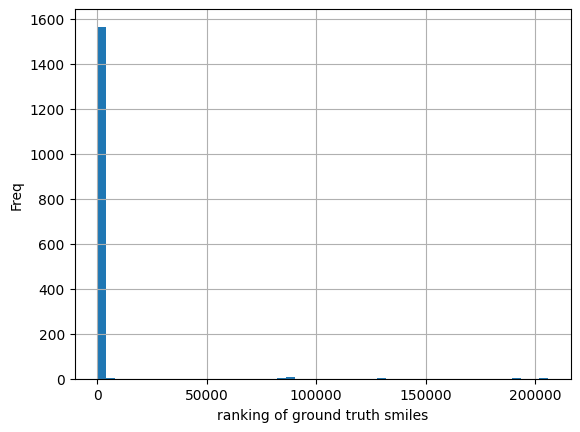

In [70]:
_=plt.hist(rankings, bins=50)
plt.grid()
plt.xlabel('ranking of ground truth smiles')
plt.ylabel('Freq')
#plt.yscale('log')

In [71]:
rankings

array([0., 7., 0., ..., 3., 0., 0.])

In [72]:
# just for visualization
rankings_x = np.arange(0,400)

In [73]:
rankings[rankings<1].shape[0]/rankings.shape[0]

0.6271401395053899

In [74]:
rankings_proportion = [rankings[rankings<=r].shape[0]/rankings.shape[0] for r in rankings_x]

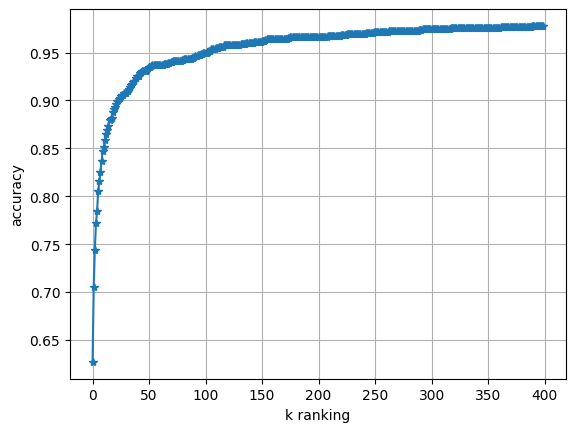

In [75]:
plt.plot(rankings_x, rankings_proportion, marker='*')
plt.xlabel('k ranking')
plt.ylabel('accuracy')
#plt.ylim([0,1])
plt.grid()

## Check the tanimoto similarity with the highest prediction

In [76]:
arg_max_sim= np.argmax(similarities_filtered, axis=1)

In [77]:
max_sim = np.max(similarities_filtered, axis=1)

In [78]:
spectrums_retrieved = [all_spectrums_reference[ind] for ind in arg_max_sim]

In [79]:
smiles_retrieved = [s.smiles for s in spectrums_retrieved]

In [80]:
smiles_janssen = [s.smiles for s in all_spectrums_janssen]

In [81]:
from src.tanimoto import Tanimoto

In [82]:
tanimoto_retrieved = [Tanimoto.compute_tanimoto_from_smiles(s0,s1) for s0, s1 in zip(smiles_janssen, smiles_retrieved)]

Text(0, 0.5, 'frequency')

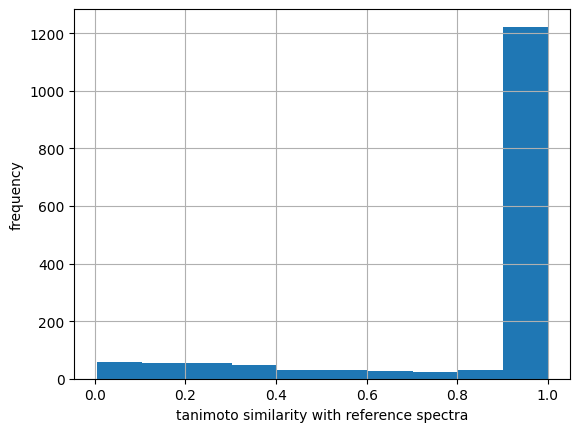

In [83]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

In [84]:
tanimoto_retrieved = np.array(tanimoto_retrieved)

In [85]:
tanimoto_retrieved[tanimoto_retrieved>0.7].shape[0]/tanimoto_retrieved.shape[0]

0.8091312618896639

## saving of results

In [86]:
similarity_name='simba_edit_distance'

In [87]:
results = {'rankings_x':rankings_x,
          'rankings_y': rankings_proportion,
           'rankings':rankings}

In [88]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_ranking.pkl', 'wb') as f:
    dill.dump(results, f)